# libraries

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import numpy as np
import random
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc,confusion_matrix, classification_report,accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

# Reading Data

{'train': {'NORMAL': 1341, 'PNEUMONIA': 3875}, 'test': {'NORMAL': 234, 'PNEUMONIA': 390}, 'val': {'NORMAL': 8, 'PNEUMONIA': 8}}


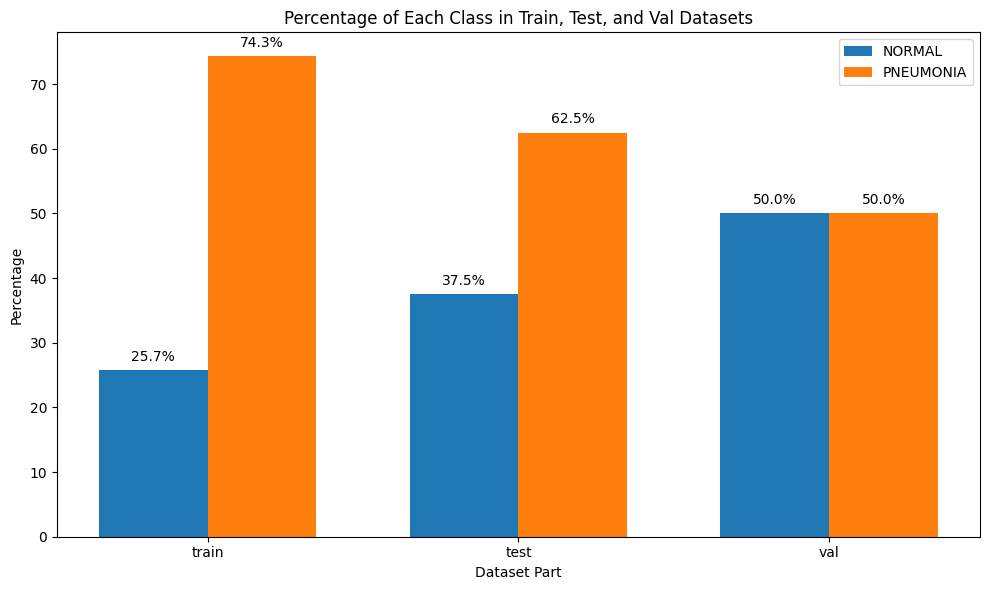

In [2]:
# Define paths to train, test, and val folders
data_dirs = {
    'train': '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    'test': '/kaggle/input/chest-xray-pneumonia/chest_xray/test',
    'val': '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
}

# Dictionary to store counts
class_counts = {key: {'NORMAL': 0, 'PNEUMONIA': 0} for key in data_dirs.keys()}

# Count images in each class folder
for part, path in data_dirs.items():
    for class_name in class_counts[part].keys():
        class_path = os.path.join(path, class_name)
        if os.path.exists(class_path):
            class_counts[part][class_name] = len([
                f for f in os.listdir(class_path) 
                if os.path.isfile(os.path.join(class_path, f))
            ])

print(class_counts)
# Calculate percentages for each part
percentages = {
    part: {cls: (count / sum(class_counts[part].values())) * 100 if sum(class_counts[part].values()) > 0 else 0
           for cls, count in counts.items()}
    for part, counts in class_counts.items()
}

# Prepare data for plotting
labels = list(percentages.keys())  # ['train', 'test', 'val']
classes = list(class_counts['train'].keys())  # ['NORMAL', 'PNEUMONIA']
data = np.array([[percentages[part][cls] for part in labels] for cls in classes])

# Plotting
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
for i, cls in enumerate(classes):
    bars = ax.bar(x + i * width, data[i], width, label=cls)
    # Add annotations to the bars
    for bar, percentage in zip(bars, data[i]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 1,
            f'{percentage:.1f}%',  # Format the percentage
            ha='center',
            va='bottom',
            fontsize=10
        )

# Add labels, title, and legend
ax.set_xlabel('Dataset Part')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Class in Train, Test, and Val Datasets')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Merge data and split 

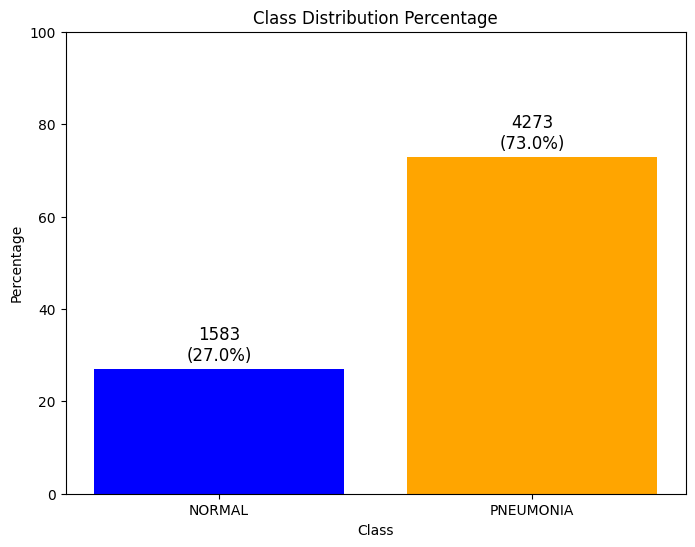

In [3]:
# Define the directories
train_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
merged_data_dir = '/kaggle/working/merged_data'

# Create merged directory with class subdirectories
os.makedirs(os.path.join(merged_data_dir, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(merged_data_dir, 'PNEUMONIA'), exist_ok=True)

# Function to copy files to the merged directory
def copy_files(source_dir, target_dir):
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_source = os.path.join(source_dir, class_name)
        class_target = os.path.join(target_dir, class_name)
        os.makedirs(class_target, exist_ok=True)
        for file_name in os.listdir(class_source):
            src_file = os.path.join(class_source, file_name)
            dst_file = os.path.join(class_target, file_name)
            shutil.copy(src_file, dst_file)

# Merge train, test, and validation datasets
copy_files(train_data_dir, merged_data_dir)
copy_files(test_data_dir, merged_data_dir)
copy_files(val_data_dir, merged_data_dir)

# Count the number of images in each class
normal_count = len(os.listdir(os.path.join(merged_data_dir, 'NORMAL')))
pneumonia_count = len(os.listdir(os.path.join(merged_data_dir, 'PNEUMONIA')))

# Plot the percentages
total_count = normal_count + pneumonia_count
normal_percentage = (normal_count / total_count) * 100
pneumonia_percentage = (pneumonia_count / total_count) * 100

# Create the bar plot
labels = ['NORMAL', 'PNEUMONIA']
percentages = [normal_percentage, pneumonia_percentage]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, percentages, color=['blue', 'orange'])

# Add the percentage and count as text above each bar
for bar, percentage, count in zip(bars, percentages, [normal_count, pneumonia_count]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate
        bar.get_height() + 1,  # Y-coordinate (slightly above the bar)
        f'{count}\n({percentage:.1f}%)',  # Text with count and percentage
        ha='center',  # Align horizontally at the center
        va='bottom',  # Align vertically above the bar
        fontsize=12,  # Text size
        color='black'  # Text color
    )

# Add labels and title
plt.title('Class Distribution Percentage')
plt.ylabel('Percentage')
plt.xlabel('Class')
plt.ylim(0, 100)
plt.show()


# Solving Imbalance (Upsampling)

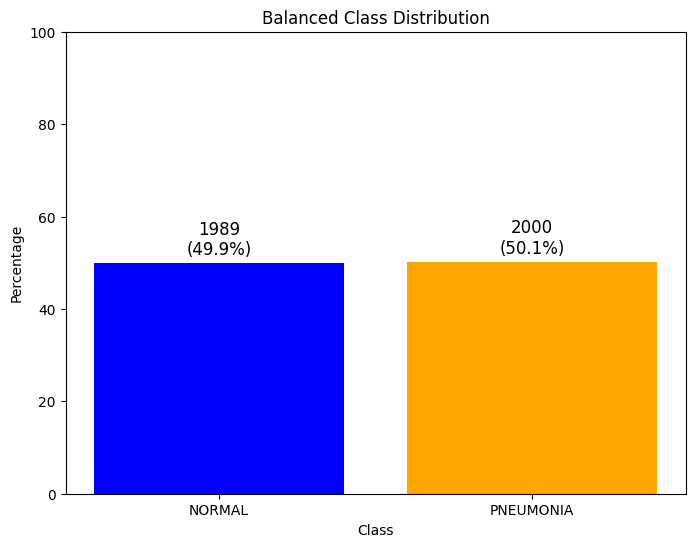

Number of NORMAL images: 1989
Number of PNEUMONIA images: 2000


In [4]:
merged_data_dir = '/kaggle/working/merged_data'
balanced_data_dir = '/kaggle/working/balanced_data'

# Create directories for balanced data
os.makedirs(os.path.join(balanced_data_dir, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(balanced_data_dir, 'PNEUMONIA'), exist_ok=True)

# Function for data augmentation
def augment_images(source_dir, target_dir, target_count):
    datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    images = os.listdir(source_dir)
    num_existing = len(images)
    if num_existing >= target_count:
        print(f"Skipping augmentation. Already have {num_existing} images.")
        return

    # Copy original images to target directory
    for img_name in images:
        shutil.copy(os.path.join(source_dir, img_name), target_dir)

    # Augment to reach the target count
    augmented_count = 0
    for img_name in images:
        img_path = os.path.join(source_dir, img_name)
        img = plt.imread(img_path)
        if len(img.shape) == 2:  # Handle grayscale images
            img = np.expand_dims(img, axis=-1)
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        for batch in datagen.flow(img, batch_size=1, save_to_dir=target_dir, save_prefix='aug', save_format='jpeg'):
            augmented_count += 1
            if num_existing + augmented_count >= target_count:
                break
        if num_existing + augmented_count >= target_count:
            break

# Process NORMAL class
normal_source = os.path.join(merged_data_dir, 'NORMAL')
normal_target = os.path.join(balanced_data_dir, 'NORMAL')
augment_images(normal_source, normal_target, 2000)

# Process PNEUMONIA class (select only 2000 images)
pneumonia_source = os.path.join(merged_data_dir, 'PNEUMONIA')
pneumonia_target = os.path.join(balanced_data_dir, 'PNEUMONIA')
pneumonia_images = os.listdir(pneumonia_source)
selected_images = random.sample(pneumonia_images, 2000)
for img_name in selected_images:
    shutil.copy(os.path.join(pneumonia_source, img_name), pneumonia_target)

# Verify and plot the new distribution
normal_count = len(os.listdir(normal_target))
pneumonia_count = len(os.listdir(pneumonia_target))

# Plot the percentages
total_count = normal_count + pneumonia_count
normal_percentage = (normal_count / total_count) * 100
pneumonia_percentage = (pneumonia_count / total_count) * 100

labels = ['NORMAL', 'PNEUMONIA']
counts = [normal_count, pneumonia_count]
percentages = [normal_percentage, pneumonia_percentage]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, percentages, color=['blue', 'orange'])

# Add the percentage and count as text above each bar
for bar, percentage, count in zip(bars, percentages, counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f'{count}\n({percentage:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=12,
        color='black'
    )

# Add labels and title
plt.title('Balanced Class Distribution')
plt.ylabel('Percentage')
plt.xlabel('Class')
plt.ylim(0, 100)
plt.show()

# Print the counts
print(f"Number of NORMAL images: {normal_count}")
print(f"Number of PNEUMONIA images: {pneumonia_count}")


# Split data

In [5]:
# Define the path to the dataset
dataset_dir = '/kaggle/working/balanced_data'
kaggle_working_dir = '/kaggle/working/splits'  # Directory where Kaggle expects the data

# Get image paths and their corresponding labels
image_paths = []
labels = []

# Iterate over the subdirectories (NORMAL and pneumonia)
for label in ['NORMAL', 'PNEUMONIA']:
    label_path = os.path.join(dataset_dir, label)
    
    if os.path.isdir(label_path):
        for image_name in os.listdir(label_path):
            image_paths.append(os.path.join(label_path, image_name))
            labels.append(label)  # Label is either 'NORMAL' or 'pneumonia'

# Shuffle the data before splitting (using random_state for reproducibility)
shuffled_image_paths, shuffled_labels = zip(*sorted(zip(image_paths, labels), key=lambda x: os.urandom(16)))

# Split the data into train and remaining sets (85% train, 15% remaining), stratified by the labels
train_image_paths, remaining_image_paths, train_labels, remaining_labels = train_test_split(
    shuffled_image_paths, shuffled_labels, test_size=0.15, stratify=shuffled_labels, random_state=42
)

# Now split the remaining data into validation and test (50% each of the remaining, i.e., 7.5% validation and 7.5% test)
val_image_paths, test_image_paths, val_labels, test_labels = train_test_split(
    remaining_image_paths, remaining_labels, test_size=0.5, stratify=remaining_labels, random_state=42
)

# Create the directories for train, validation, and test, including subdirectories for each class
train_dir = os.path.join(kaggle_working_dir, 'train')
val_dir = os.path.join(kaggle_working_dir, 'val')
test_dir = os.path.join(kaggle_working_dir, 'test')

# Create class-specific directories inside train, val, and test
os.makedirs(os.path.join(train_dir, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'PNEUMONIA'), exist_ok=True)

os.makedirs(os.path.join(val_dir, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'PNEUMONIA'), exist_ok=True)

os.makedirs(os.path.join(test_dir, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'PNEUMONIA'), exist_ok=True)

# Function to move images to the target directories, ensuring they go into the correct class subfolder
def move_images(image_paths, labels, target_dir):
    for image_path, label in zip(image_paths, labels):
        # Move the image to the corresponding class subdirectory
        class_dir = os.path.join(target_dir, label)
        shutil.copy(image_path, class_dir)  # Copy the image to the target class subfolder

# Move the train images
move_images(train_image_paths, train_labels, train_dir)

# Move the validation images
move_images(val_image_paths, val_labels, val_dir)

# Move the test images
move_images(test_image_paths, test_labels, test_dir)

# Check the directories and count the number of images in each set
for subset in ['train', 'val', 'test']:
    for label in ['NORMAL', 'PNEUMONIA']:
        subset_dir = os.path.join(kaggle_working_dir, subset, label)
        print(f"{subset.capitalize()} - {label} directory contains {len(os.listdir(subset_dir))} images.")


Train - NORMAL directory contains 1690 images.
Train - PNEUMONIA directory contains 1700 images.
Val - NORMAL directory contains 149 images.
Val - PNEUMONIA directory contains 150 images.
Test - NORMAL directory contains 150 images.
Test - PNEUMONIA directory contains 150 images.


# Images Shape

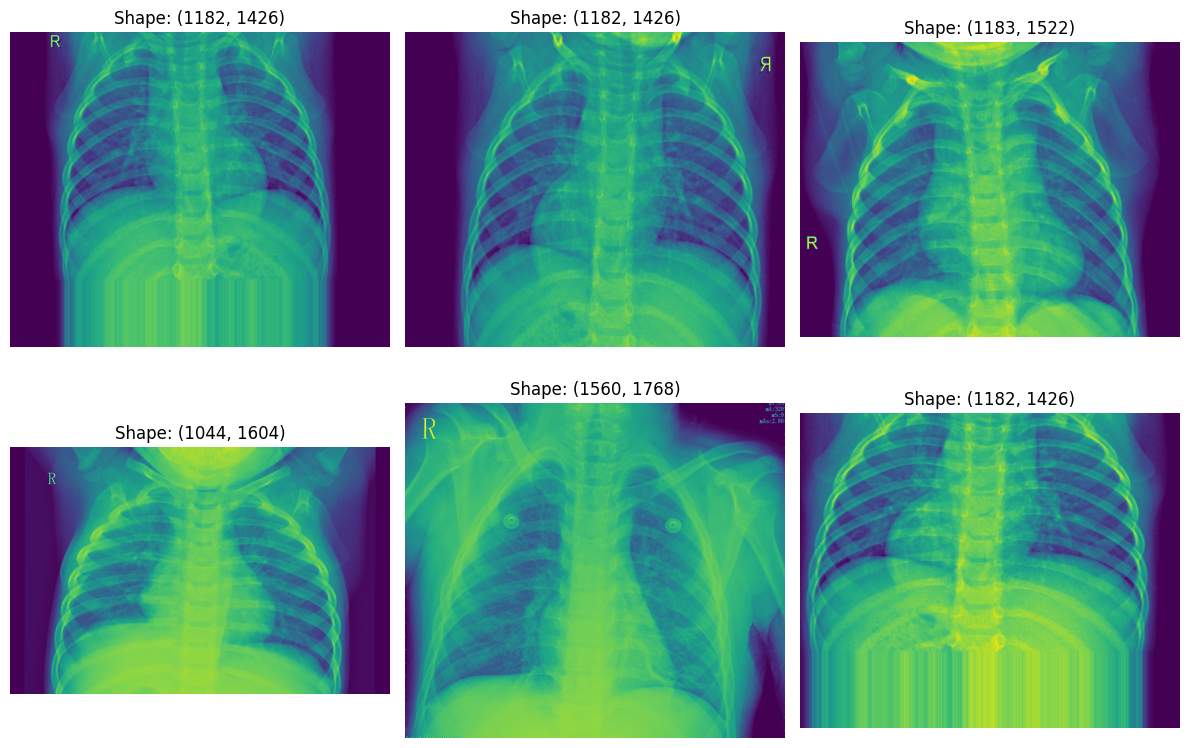

In [6]:
# Path to the train folder
train_folder_path = '/kaggle/working/splits/train'

# List all images in the train folder (assuming there are subfolders for each class)
image_paths = []
for root, dirs, files in os.walk(train_folder_path):
    for file in files:
        # Ensure the file is an image (you can add more file extensions if needed)
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

# Randomly select 6 images
selected_images = random.sample(image_paths, 6)

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

# Loop through images and plot each one
for i, image_path in enumerate(selected_images):
    img = Image.open(image_path)
    img_array = img  # Use Pillow for image handling

    # Get image dimensions (width, height)
    img_shape = np.array(img).shape  # (width, height)

    # Plot image
    axes[i].imshow(img_array)
    axes[i].axis('off')  # Hide axis for better viewing
    axes[i].set_title(f"Shape: {img_shape}")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


# Setting up Train, Test, Val Image Data Genrator

In [7]:
# Directory paths for training ,testing and validation datasets
train_data_dir = '/kaggle/working/splits/train'
test_data_dir = '/kaggle/working/splits/test'
val_data_dir = '/kaggle/working/splits/val'
print(train_data_dir)

# Set up the ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)  
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),  # Resize the images to 299x299
    batch_size=16,
    class_mode='binary',  # For binary classification
    color_mode='rgb', 
     shuffle=True # Ensure the images are 3 channels (RGB)
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(299, 299),  
    batch_size=16,
    class_mode='binary',  
    color_mode='rgb',  
    shuffle=False  # Important: Don't shuffle so we can match labels with predictions
)



test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(299, 299),  
    batch_size=16,
    class_mode='binary',  
    color_mode='rgb',  
    shuffle=False  # Important: Don't shuffle so we can match labels with predictions
)


/kaggle/working/splits/train
Found 3390 images belonging to 2 classes.
Found 299 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


# Xception Model

In [13]:
# Load the Xception model pre-trained on ImageNet, excluding the top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(1, activation='sigmoid')(x)  # Output layer (assuming binary classification)

# Create the new model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with a learning rate suitable for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Unfreeze the last 20 layers of the model
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Recompile the model after unfreezing
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=16,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Optionally, save the model after fine-tuning
model.save('/kaggle/working/fine_tuned_xception_model.h5')

# Save the training history
with open('/kaggle/working/training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


Epoch 1/16
211/211 ━━━━━━━━━━━━━━━━━━━━ 54s 210ms/step - accuracy: 0.9121 - loss: 0.2463 - val_accuracy: 0.9618 - val_loss: 0.1130
Epoch 2/16
  1/211 ━━━━━━━━━━━━━━━━━━━━ 31s 151ms/step - accuracy: 0.8125 - loss: 0.2819

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8125 - loss: 0.2819 - val_accuracy: 0.8182 - val_loss: 0.7400
Epoch 3/16
211/211 ━━━━━━━━━━━━━━━━━━━━ 38s 175ms/step - accuracy: 0.9655 - loss: 0.0909 - val_accuracy: 0.9583 - val_loss: 0.1140
Epoch 4/16
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.9091 - val_loss: 0.3097
Epoch 5/16
211/211 ━━━━━━━━━━━━━━━━━━━━ 39s 177ms/step - accuracy: 0.9813 - loss: 0.0575 - val_accuracy: 0.9792 - val_loss: 0.0905
Epoch 6/16
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9091 - val_loss: 0.5470
Epoch 7/16
211/211 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - accuracy: 0.9836 - loss: 0.0439 - val_accuracy: 0.9618 - val_loss: 0.1051
Epoch 8/16
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 0.9091 - val_loss: 0.4291
Epoch 9/16
211/211 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - accuracy: 0.9938 - loss: 0.0182 - val_accur

# Accuracy and Loss curves

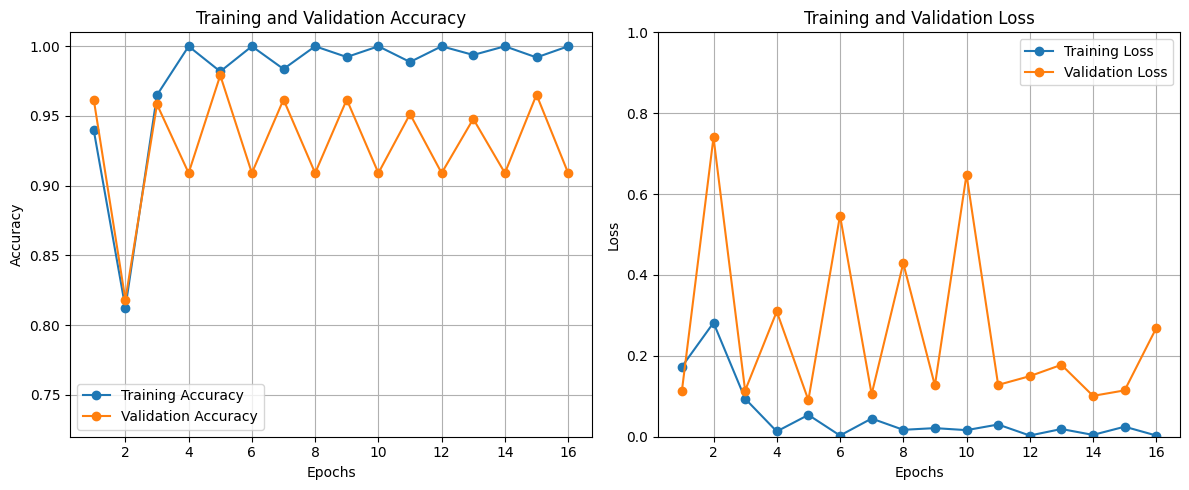

In [38]:
import pickle
import matplotlib.pyplot as plt

# Load the saved training history
with open('/kaggle/working/training_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

# Extract accuracy and loss for training and validation
accuracy = loaded_history['accuracy']
val_accuracy = loaded_history['val_accuracy']
loss = loaded_history['loss']
val_loss = loaded_history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0.72, 1.01)  # Adjusted y-axis range for smoother view

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.0)  # Adjusted y-axis range for smoother view

# Show plots
plt.tight_layout()
plt.show()


# Confusion Matrix

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step


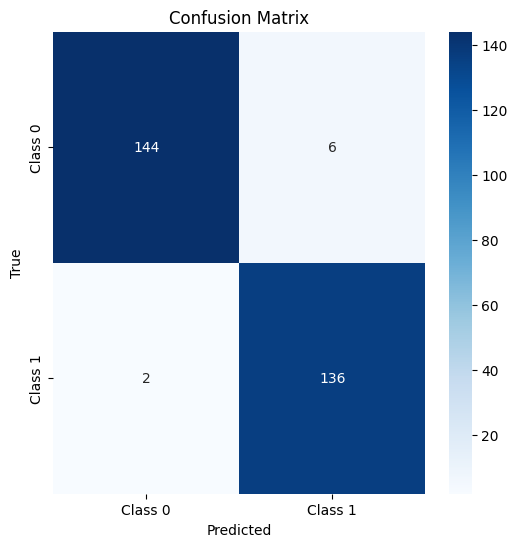

In [40]:
#Get the true labels and predicted probabilities
true_labels = test_generator.classes  # Get true labels
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Convert predictions to binary values (0 or 1)
predicted_labels = (predictions > 0.5).astype("int32")

# Check if the true labels and predicted labels have the same number of samples
if len(true_labels) != len(predicted_labels):
    # If not, adjust the length of the true_labels to match predictions
    true_labels = true_labels[:len(predicted_labels)]

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Percision, Recall, F1-score

In [41]:
class_report = classification_report(true_labels, predicted_labels, target_names=['NORMAL', 'PNEUMONIA'], output_dict=True)

report_df = pd.DataFrame(class_report).transpose()
report_df = report_df.round(2)

print("Classification Report:")
print(tabulate(report_df, headers='keys', tablefmt='fancy_grid'))

Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ NORMAL       │        0.99 │     0.96 │       0.97 │    150    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ PNEUMONIA    │        0.96 │     0.99 │       0.97 │    138    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │        0.97 │     0.97 │       0.97 │      0.97 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │        0.97 │     0.97 │       0.97 │    288    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │        0.97 │     0.97 │       0.97 │    288    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


# AUC and ROC curve

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step


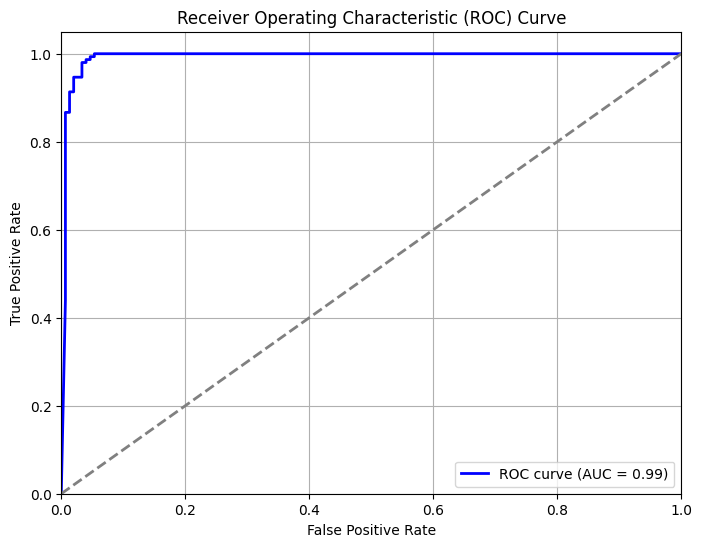

In [42]:
# Get true labels and predicted probabilities for the test set
true_labels = test_generator.classes  # Ground truth labels
predicted_probs = model.predict(test_generator)  # Model predictions (probabilities)

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)  # False Positive Rate, True Positive Rate
roc_auc = auc(fpr, tpr)  # Area Under the ROC Curve

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Explainable Technique (Grad Cam)

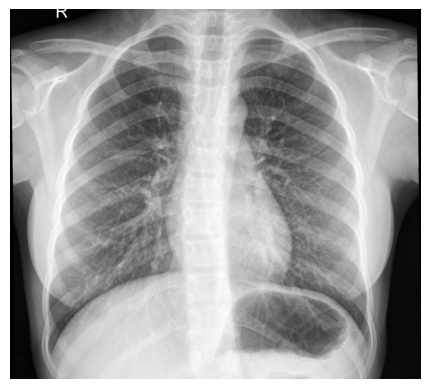

In [44]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Function to load and preprocess the image
def preprocess_image(img_path, target_size=(299, 299)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.xception.preprocess_input(img_array)
    return img_array

# Grad-CAM function
def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    # Create a model that maps input image to the activations of the last conv layer and output
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute gradients
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]
    
    # Compute gradients of the class output with respect to the conv layer
    grads = tape.gradient(class_output, conv_output)
    
    # Pool gradients over all axes except depth
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the feature maps by the pooled gradients
    conv_output = conv_output[0]
    heatmap = np.dot(conv_output, pooled_grads)
    
    # Apply ReLU and normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Superimpose Grad-CAM heatmap on the image
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    
    # Resize heatmap to match the image size
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1]))
    heatmap = tf.squeeze(heatmap, axis=-1)
    
    # Normalize the heatmap to be in the range [0, 255]
    heatmap = np.uint8(255 * heatmap)
    
    # Apply colormap to the heatmap (use the normalized heatmap as indices)
    jet = plt.cm.jet(np.arange(256))[:, :3]
    jet_heatmap = jet[heatmap]
    jet_heatmap = np.uint8(jet_heatmap)
    
    # Combine the original image with the heatmap
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    
    # Display the image with the Grad-CAM heatmap
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Path to your test image
img_path = '/kaggle/working/splits/test/NORMAL/IM-0033-0001-0001.jpeg'  # Replace with your image path

# Preprocess the image
img_array = preprocess_image(img_path)

# Specify the last convolutional layer's name in the Xception model
last_conv_layer_name = 'block14_sepconv2_act'  # Xception's final convolutional layer

# Generate the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(model, img_array, last_conv_layer_name)

# Display the Grad-CAM heatmap superimposed on the original image
display_gradcam(img_path, heatmap)
